In [1]:
import numpy
from PIL import Image, ImageCms
import datetime
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import os

In [2]:
# Inlezen file
bepaalDominanteKleurenDir = '/home/willem/PycharmProjects/CamoBuilder/bepaalDominanteKleuren/'
kleurParametersDir = '/home/willem/PycharmProjects/CamoBuilder/kleurParameters/'
name = 'lenteAlmer.jpg'
sampleSize = 1000

In [4]:
im = Image.open(bepaalDominanteKleurenDir + name)
if im.mode != "RGB":
    im = im.convert("RGB")

srgb_profile = ImageCms.createProfile("sRGB")
lab_profile = ImageCms.createProfile("LAB")
rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
lab_im = ImageCms.applyTransform(im, rgb2lab_transform)
w, h = lab_im.size
labColors = lab_im.getcolors(w * h)
npImageOrig = np.array(lab_im)
npImage = npImageOrig.reshape(w * h, 3)
pdImage = pd.DataFrame(npImage, columns=['L', 'A', 'B'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/willem/PycharmProjects/CamoBuilder/bepaalDominanteKleuren/lenteAlmer.jpg'

In [4]:
wcss = []
start = 4
end = 17
for i in range(start, end):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter= 300, n_init= end - start, random_state= 0)
  kmeans.fit(pdImage)
  wcss.append(kmeans.inertia_)
plt.plot(range(start, end),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters K')
plt.ylabel('Average Within-Cluster distance to Centroid (WCSS)')  
plt.show()

KeyboardInterrupt: 

In [4]:
aantalKleuren = 10 # Op basis van grafiek
kmeans = KMeans(n_clusters=aantalKleuren)
kmeans.fit(pdImage)
NkleurenKMeansPredicted = kmeans.predict(pdImage)
npCenters = kmeans.cluster_centers_.astype(int)

In [5]:
if sampleSize > pdImage['L'].size:
    sampleSize = pdImage['L'].size
selectie = random.sample(list(range(0, pdImage['L'].size)), sampleSize)
L = pdImage.iloc[selectie, 0]
A = pdImage.iloc[selectie, 1]
B = pdImage.iloc[selectie, 2]
C = NkleurenKMeansPredicted[selectie]

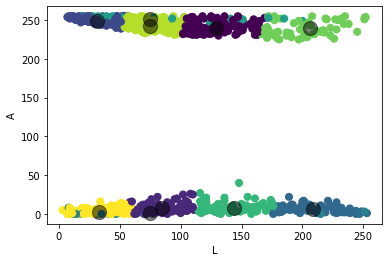

In [6]:
fig, ax = plt.subplots()
ax.scatter(L, A, c=C, s=50, cmap='viridis')
ax.set_xlabel('L')
ax.set_ylabel('A')
ax.scatter(npCenters[:, 0], npCenters[:, 1], c='black', s=200, alpha=0.5)
plt.show()

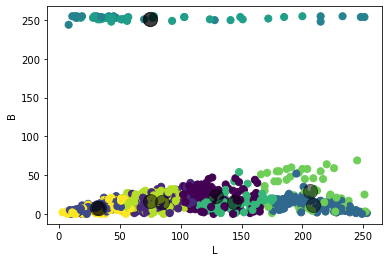

In [7]:
fig, ax = plt.subplots()
ax.scatter(L, B, c=C, s=50, cmap='viridis')
ax.set_xlabel('L')
ax.set_ylabel('B')
ax.scatter(npCenters[:, 0], npCenters[:, 2], c='black', s=200, alpha=0.5)
plt.show()

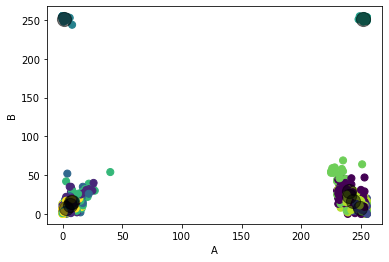

In [8]:
fig, ax = plt.subplots()
ax.scatter(A, B, c=C, s=50, cmap='viridis')
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.scatter(npCenters[:, 1], npCenters[:, 2], c='black', s=200, alpha=0.5)
plt.show()

In [15]:
pdImage['verdeling_in_N'] = NkleurenKMeansPredicted
pdCenters = pd.DataFrame(npCenters, columns=['Ln', 'An', 'Bn'])
print(pdCenters)

    Ln   An   Bn
0  129  240   23
1   85    7   15
2   31  249    8
3  209    6   12
4   75    1  252
5   75  252  252
6  144    8   16
7  206  240   30
8   75  243   17
9   33    3    7


In [16]:
pdCenters['verdeling_in_N'] = list(range(0, aantalKleuren))
pdImageTransform = pdImage.join(pdCenters.set_index('verdeling_in_N'), on='verdeling_in_N')
pdImageNieuwNcolor = pdImageTransform.iloc[:, 4:7]

Nu gaan we de gevonden centers opnieuw verdelen met behulp van KNN.Daarom gaan we eerst de A en de B pakken van pdImageNieuwNcolor

In [11]:
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(pdImageNieuwNcolor.loc[:, ['An', 'Bn']])
kleuren2KMeansPredicted = kmeans2.predict(pdImageNieuwNcolor.loc[:, ['An', 'Bn']])
npCenters2 = kmeans2.cluster_centers_.astype(int)
print(npCenters2)

[[244  24]
 [  5  25]]


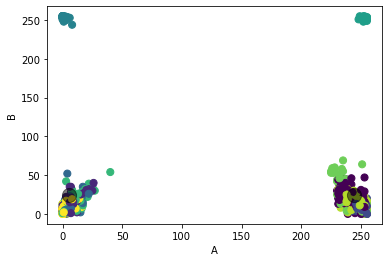

In [12]:
# A, B en C zijn al eerder uitgerekend
fig, ax = plt.subplots()
ax.scatter(A, B, c=C, s=50, cmap='viridis')
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.scatter(npCenters2[:, 0], npCenters2[:, 1], c='black', s=200, alpha=0.5)
plt.show()

Transformatie matrix uitbreiden met 2 kleuren indeling

In [26]:
pdImageTransform['verdeling_in_2'] = kleuren2KMeansPredicted
pdCenters2 = pd.DataFrame(npCenters2, columns=['A2', 'B2'])
pdCenters2['verdeling_in_2'] = list(range(0, 2))
pdImageTransform = pdImageTransform.join(pdCenters2.set_index('verdeling_in_2'), on='verdeling_in_2')

In [29]:
pdImageNieuw2color = pdImageTransform.iloc[:, [8, 9]]
pdImageNieuw2color.insert(0, 'L2', 128)

Plaatje met N kleuren

In [18]:
npImageNieuwNcolor = pdImageNieuwNcolor.to_numpy()
npImageNieuwNcolor = npImageNieuwNcolor.reshape(h, w, 3, order="C")
imageNieuwNcolor = Image.fromarray(numpy.uint8(npImageNieuwNcolor),
                            mode='LAB')
lab2rgb_transform = ImageCms.buildTransformFromOpenProfiles(lab_profile, srgb_profile, "LAB", "RGB")
imgRGBnieuwNcolor = ImageCms.applyTransform(imageNieuwNcolor, lab2rgb_transform)
now = datetime.datetime.now().strftime('%Y%m%d %H%M%S')
imgRGBnieuwNcolor.save(bepaalDominanteKleurenDir + "/" + name + now + " vervangenVolgensMapN.JPG")

Plaatje met 2 kleuren maar wel met de oorspronkelijke N-lichtsterkten

In [30]:
npImageNieuw2color = pdImageNieuw2color.to_numpy()
npImageNieuw2color = npImageNieuw2color.reshape(h, w, 3, order="C")
imageNieuw2color = Image.fromarray(numpy.uint8(npImageNieuw2color),
                            mode='LAB')
lab2rgb_transform = ImageCms.buildTransformFromOpenProfiles(lab_profile, srgb_profile, "LAB", "RGB")
imgRGBNieuw2color = ImageCms.applyTransform(imageNieuw2color, lab2rgb_transform)
now = datetime.datetime.now().strftime('%Y%m%d %H%M%S')
imgRGBNieuw2color.save(bepaalDominanteKleurenDir + "/" + name + now + " vervangenVolgensMap2.JPG")

Maken van kleuren en tellingen

In [20]:
# Maken van kleuren en tellingen N
npImageRGBnieuwNcolor = np.array(imgRGBnieuwNcolor)
npImageRGBnieuwNcolor = npImageRGBnieuwNcolor.reshape(w * h, 3)
pdImageRGBnieuwNcolor = pd.DataFrame(npImageRGBnieuwNcolor, columns=['R', 'G', 'B'])
pdImageRGBnieuwNcolor['aantal'] = 1
tellingen_N = pdImageRGBnieuwNcolor.groupby(['R', 'G', 'B'])['aantal'].count().reset_index()

Toevoegen van 2 kleuren.
We zien op dit moment alleen RGB de vraag is dus hoe te koppelen.
Het antwoord: via de aantallen?

In [23]:
pdImageTransform['aantal'] = 1
tellingen_2 = pdImageTransform.groupby(['Ln', 'An', 'Bn', 'verdeling_in_N', 'verdeling_in_2'])['aantal'].count().reset_index()
export = tellingen_N.join(tellingen_2.set_index('aantal'), on='aantal').iloc[:,[0, 1, 2, 3, 7, 8]]

In [32]:
print(export)
export.to_csv(kleurParametersDir + name + now + '.csv')

     R    G    B   aantal  verdeling_in_N  verdeling_in_2
0   25   34   20  8253446               2               0
1   40   32   24  4188704               9               1
2   55   75   42  6161931               8               0
3   59   71   75   748040               5               0
4   68   69   75   814702               4               1
5   95   74   55  3785641               1               1
6  103  128   80  3839632               0               0
7  157  130  108  3145712               6               1
8  186  209  143  1845078               7               0
9  222  199  182  3217114               3               1


In [2]:
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 8.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=be2a6d9f4bac3fa1bb6281b1471a30bccd1aeffd429afa1165a10638a4864a50
  Stored in directory: /home/willem/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn
